In [ ]:
!pip install imblearn

In [2]:
import os
import time
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import entropy
from numpy.lib.stride_tricks import sliding_window_view
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# 1) Import dataset, apply knowledge-based and criteria-based pruning

In [16]:
df = pd.read_csv('journal_bearing.csv')
header = ['speed', 'eccentricity', 'load', 'axial_pos', 'angular_pos', 'thickness', 'pressure']
df.columns = header
# Choose values of eccentricity between 0.3, 0.7 (Knowledge pruning)
df = df[df['eccentricity'].between(0.3, 0.7)]
# Remove the upcoming values that correspond to zero at any input
zero_pressure_condition = (df['angular_pos']<-2.7) | (df['angular_pos']>1.37)
df = df[~zero_pressure_condition]
df = df.drop(columns=['eccentricity', 'thickness'])
df

,speed,load,axial_pos,angular_pos,pressure
2856028,209.439510,2379.22,0.000000,-2.686062,0.0
2856029,209.439510,2379.22,0.000000,-2.670354,0.0
2856030,209.439510,2379.22,0.000000,-2.654646,0.0
2856031,209.439510,2379.22,0.000000,-2.638938,0.0
2856032,209.439510,2379.22,0.000000,-2.623230,0.0
...,...,...,...,...,...
35495882,1047.197551,58880.20,0.038974,1.303761,0.0
35495883,1047.197551,58880.20,0.038974,1.319469,0.0
35495884,1047.197551,58880.20,0.038974,1.335177,0.0
35495885,1047.197551,58880.20,0.038974,1.350885,0.0


# 2) Introducing every IS algorithm

## 2.1 Random Sampling

In [4]:
def random_IR(df):
    """
    (Instance selection -> Random Sampling)
    
    Args:
        df : dataframe (Full dataset)

    Returns:
        Indices of Chosen points.
        
    """
    # Choose random rows from the DataFrame (90% reduction -> 10% of the dataset)
    sampled_percent = 0.1
    random_rows_indices = df.sample(n=int(sampled_percent*df.shape[0]), random_state=42).index
    return random_rows_indices

## 2.2 Adaptive DBSCAN

In [5]:
def reshape_df(df):
    reshaped_df = df.groupby(['speed', 'angular_pos', 'axial_pos']).agg({'load': list, 'pressure': list}).reset_index()
    reshaped_df = reshaped_df.explode(['load', 'pressure']).reset_index(drop=True)
    reshaped_df['difference'] = reshaped_df['pressure'] - reshaped_df['pressure'].shift(1)
    # Taking absolute difference
    reshaped_df['difference'] = reshaped_df['difference'].abs()
    # Fill in nan with zeros
    reshaped_df['difference'] = reshaped_df['difference'].fillna(0)
    reshaped_columns = list(df.columns) + ['difference']
    reshaped_df = reshaped_df.reindex(columns=reshaped_columns)
    return reshaped_df

def select_indices_load(df):
    """
    Retrieves the representitive points along load dimension. Supply the func with dataframe.
    
    Args:
        df (dataframe)

    Returns:
        Indices of representitive points along load dimension.
        
    Example:
        >>> select_indices_load(df)
        [3, 13, 23]
    """
    df_indices = np.array(df.index)
    data = np.array(df['difference'])  
    # Calculate the standard deviation and mean
    std_dev = np.std(data)
    mean = np.mean(data)
    # Threshold for defining a spike
    threshold_in_std = 1
    # Calculate modified z-scores using standard deviation
    mod_z_scores = np.abs(data - mean) / std_dev
    # Create a boolean flag list: True if the point is a spike, False otherwise
    spike_flags = mod_z_scores > threshold_in_std
    spike_flags = spike_flags.astype(int)
    # First and last element are marked as 1
    spike_flags[[0, -1]] = 1
    # If there are no spikes (normal graph) then sample some of the points in between
    # sum(spike_flags) is a threshold at which points are sampled uniformly. If bigger than the threshold -> Choosing points will be based on spikes
    # Also, if All pressure values equal to 0, then sample uniformly from the distribution
    if sum(spike_flags) <= 15 or (df['difference'].unique()[0]==0 and len(df['difference'].unique())==1):
        equal_separabale_indices = np.linspace(0, 239, num=24, dtype=int)
        ind = df.index
        # Extract the corresponding points from the array
        representitive_indices = ind[equal_separabale_indices]
    else: 
        epsilon = mean + std_dev
        # Perform DBSCAN clustering
        dbscan = DBSCAN(eps=epsilon, min_samples=1)
        pressures_loads = df[['pressure', 'load']].values
        labels = dbscan.fit_predict(pressures_loads)
        # Identify unique labels
        unique_labels = np.unique(labels)
        middle_indices = []

        for label in unique_labels:
            # indices of points with current label
            label_indices = np.where(labels == label)[0]
            # Compute the middle index (Sampled point)
            middle_index = label_indices[len(label_indices) // 2]
            middle_indices.append(middle_index)
        representitive_indices = df_indices[middle_indices]
    return representitive_indices


def reduce_dataset(df, reduction_dimension, method):
    """
    Reshapnig df for using in adaptive DBSCAN
    
    Args:
        df : Our reshaped dataframe (Full dataset)

    Returns:
        Indices of Chosen points.
        
    """
    if reduction_dimension=='axial_pos': return select_indices_axial(df)
    # Block step is chosen as 240 as this is the number of points insided a group shown in the graph
    block_step = 240
    blocks = int(df.shape[0]/block_step)
    count = 0
    chosen_indices = np.array([])
    for start_row in range(blocks):
        start = start_row*block_step
        end = start + block_step
        block_df = df[start:end]
        picked_indices = select_indices_load(block_df)
        chosen_indices = np.concatenate((chosen_indices, picked_indices)).astype(int)
    return chosen_indices


## 2.3 Selesup for regression

In [7]:
import time
from numpy import zeros, isin, arange, std, abs, array, where
from pandas import DataFrame, concat
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

class selesup:
    def __init__(self, df, f, alpha, target_col, normalize):
        self.f = f
        self.target_col = target_col
        self.df = df
        self.alpha = alpha
        self.normalize = normalize
         
    def split_dataset(self):
        if self.normalize:
            scaler = StandardScaler()
            columns = [col for col in self.df.columns if col!=self.target_col]
            self.df[columns] = scaler.fit_transform(self.df[columns])
        df_indices = arange(self.df.shape[0])
        # Split the DataFrame into f and 1-f. The split is done in order.
        # Retrieve the indices of WBC and suppression sets
        (self.WBC_indices, self.suppression_set_indices) = train_test_split(df_indices, test_size=1-self.f, shuffle=False)
    
    def Nearest_Neighbors(self):
        X = self.df.drop(columns=['index', self.target_col])
        # Retrieving 3 nearest neighbors for every pathogen
        # We are interested in the first 2 nearest neighbors, we are using k=3 as the pathogen itself is the first nearest neighbour
        nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto').fit(X)
        _, nn_indices = nbrs.kneighbors(self.df.iloc[self.suppression_set_indices].drop(columns=['index', self.target_col]))
        return nn_indices[:, 1:]
    
    def scoring_wbc(self, row):
        self.counter+=1
        X_supp = row.drop([self.target_col])
        y_supp = row[self.target_col]
        supp_index = row.name
        supp_index_nn = row.name - self.suppression_set_indices[0]
        supp_nns = self.nn_indices[supp_index_nn]
        supp_wbc_nn = supp_nns
        # This line used to retrieve the nearest WBC neighbours excluding pathogens, however, it takes time searching for millions of rows
        # For simplicity, we will assume that the nearest neighbours are WBCs ONLY and no pathogens are present as nearest neighbours to the other
        #supp_wbc_nn = supp_nns[np.in1d(supp_nns, self.WBC_indices)]
        first_wbc_nn = self.df.iloc[supp_wbc_nn[0]]
        X_temp = first_wbc_nn.drop(['index', self.target_col])
        X_first = X_temp.values.reshape(-1, X_temp.shape[0])
        y_first = first_wbc_nn[self.target_col]
        second_wbc_nn = self.df.iloc[supp_wbc_nn[1]]
        standard_dev = std([y_supp, second_wbc_nn[self.target_col]])
        theta = self.alpha * standard_dev
        df_supp_nn = self.df.iloc[[supp_index, supp_wbc_nn[1]]]
        X = df_supp_nn.drop(columns=['index', self.target_col]).values
        y = df_supp_nn[self.target_col].values
        reg = LinearRegression().fit(X, y)
        y_pred = reg.predict(X_first)
        # Threshold that determines if the WBC would be considered as representitive
        if abs(y_first - y_pred) < theta:
            self.scores[supp_wbc_nn[0]] += 1
        if self.counter%1000000 == 0:
            print(f"Current counter: {self.counter}. Time since last counter {time.time() - self.start_time}")
            
    def reduce(self, shuffle):
        if shuffle: self.df = self.df.sample(frac=1, random_state=42)  # Set random_state for reproducibility
        self.split_dataset()
        self.df = self.df.reset_index(drop=False)
        # This function retrieves the Nearest Neighbors
        print('Started NN')
        self.nn_indices = self.Nearest_Neighbors()
        print('Finished NN')
        nn_instance = self.nn_indices[0]
        # Nearest neighbors of the suppresor instance from WBC
        wcb_nn = nn_instance[isin(nn_instance, self.WBC_indices)]
        # Nearest neighbors of the suppresor instance from suppresors
        suppressor_nn = nn_instance[~isin(nn_instance, self.WBC_indices)]
        # Initializing zero scores for all the WBC instances
        self.scores = zeros(df.shape[0])
        suppression_set = self.df.iloc[self.suppression_set_indices]
        self.counter=0
        self.start_time = time.time()
        suppression_set.apply(self.scoring_wbc, axis=1)
        # bool_mask for the WBC instances that has scores >=1
        self.chosen_wcb_indices = where(self.scores == 1)[0]
        return self.df.iloc[self.chosen_wcb_indices]

    def draw(self):
        X_full = self.df.drop(columns=['index', self.target_col]).values
        y_full = self.df[self.target_col].values
        X_reduced = self.df.iloc[self.chosen_wcb_indices].drop(columns=['index', self.target_col]).values
        y_reduced = self.df.iloc[self.chosen_wcb_indices][self.target_col].values
        X_supp = self.df.iloc[self.suppression_set_indices].drop(columns=['index', self.target_col]).values
        y_supp = self.df.iloc[self.suppression_set_indices][self.target_col].values 
        plt.scatter(X_full, y_full, color='red', alpha=0.5)
        plt.scatter(X_reduced, y_reduced, label='Picked instances', color='green', alpha=0.8)
        plt.scatter(X_supp, y_supp, label='Suppressor instances', color='blue', alpha=0.8)
        plt.xlabel('Input')
        plt.ylabel('Output')
        plt.legend()
        plt.show()
        

'''data = {
    #'X1': list(range(17000000)),
    #'X2': list(range(17000000)),
    #'X3': list(range(17000000)),
    #'X4': list(range(17000000)),
    'X2': list(range(12)),
    'pressure': [15, 22, 300, 84, 25, 65, 7, 812, 459, 105, 151, 12]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create an instance of selesup
start = time.time()
algorithm = selesup(df, f=0.90, alpha=2, target_col='pressure', normalize='True')
reduced_df = algorithm.reduce(shuffle=True)
#print(f"Time taken: {round(time.time()-start, 2)} sec")
algorithm.draw()'''

'data = {\n    #\'X1\': list(range(17000000)),\n    #\'X2\': list(range(17000000)),\n    #\'X3\': list(range(17000000)),\n    #\'X4\': list(range(17000000)),\n    \'X2\': list(range(12)),\n    \'pressure\': [15, 22, 300, 84, 25, 65, 7, 812, 459, 105, 151, 12]\n}\n\n# Create a DataFrame\ndf = pd.DataFrame(data)\n\n# Create an instance of selesup\nstart = time.time()\nalgorithm = selesup(df, f=0.90, alpha=2, target_col=\'pressure\', normalize=\'True\')\nreduced_df = algorithm.reduce(shuffle=True)\n#print(f"Time taken: {round(time.time()-start, 2)} sec")\nalgorithm.draw()'

## 2.4 Regression Autoencoder

In [8]:
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Reduce dataset using stratified sampling on embeddings

class IS_regression_autoencoder:
    def __init__(self, path):
        self.path = path
        
    def get_encoder_from_autoencoder(self, autoencoder, encoder_output_name):
        encoder_output = autoencoder.get_layer(encoder_output_name).output
        encoder = Model(inputs=autoencoder.input, outputs=encoder_output)
        return encoder

    def load_autoencoder(self):
        loaded_autoencoder = load_model(self.path)
        # Extract encoder architecture from the loaded autoencoder
        input_layer = loaded_autoencoder.input

        # Use the function to extract the encoder
        self.loaded_encoder = self.get_encoder_from_autoencoder(loaded_autoencoder, encoder_output_name='encoder_output')
        
    def predict(self, X_train_normalized):
        # Reduce dimensions
        # This line uses the encoder to output the embeddings
        embeddings = self.loaded_encoder.predict(X_train_normalized)
        return embeddings

    def draw_embeddings(self):
        # Hexbin plot
        plt.hexbin(encoded_data[:,0], encoded_data[:,1], gridsize=50, cmap='Greys')
        plt.colorbar()
        plt.title("Hexbin Plot of 2D Representations")
        plt.show()
    
    def reduce_data_stratified_sampling(self, encoded_data, y):
        # First fit the data using KMeans clustering 
        kmeans = KMeans(n_clusters=3)
        clusters = kmeans.fit_predict(encoded_data)
        # Stratified sampling
        splits = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
        for train_index, sample_index in splits.split(encoded_data, clusters):
            sampled_data = encoded_data[sample_index]
            # Get the original indices from y's index
            original_sampled_indices = y.index[sample_index]
            sampled_clusters = clusters[sample_index]
        return original_sampled_indices

## 2.5 RegCNN and RegENN
## Note: This method is implemented but takes a lot of time. Out of scope of this paper

In [9]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LassoLarsCV, LinearRegression, SGDRegressor
from sklearn.neighbors import NearestNeighbors


# Base Code adopted from: https://pypi.org/project/kondo-ml/ NOTE: CODE HAS BEEN ALTERED FOR FASTER PROCESSING
class SelectorMixin:
    _estimator_type = "selector"

    def __init__(self, subsize_frac):
        self.subsize_frac = subsize_frac

    def fit_predict(self, X, y=None):
        """Perform fit on X and returns labels for X.

        Returns -1 for outliers and 1 for inliers.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The input samples.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            1 for inliers, -1 for outliers.
        """
        # override for transductive outlier detectors like LocalOulierFactor
        return self.fit(X, y).predict(X, y)

    def calc_subset_sizeint(self, nr_samples):
        return int(nr_samples * self.subsize_frac)

def train_lr_model(reg_model, X, y, model_type: str = "linear"):
    if model_type == "linear":
        reg = LinearRegression()
        reg.fit(X, y)
        return reg
        
    elif model_type=='linear_adjusted':
        reg_model.partial_fit(X, y)
        return reg_model
    

    
class RegEnnSelector(SelectorMixin, BaseEstimator):
    def __init__(self, alpha: float = 5, nr_of_neighbors: int = 9, subsize_frac=1):
        super().__init__(subsize_frac=subsize_frac)
        self.nr_of_neighbors = nr_of_neighbors
        self.alpha = alpha

    def fit(self, X, y):
        """
        Fit the algorithm according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self
            Fitted estimator.
        """
        self.nr_of_samples = X.shape[0]
        self.labels = np.ones(self.nr_of_samples, dtype="int8") * -1
        self.scores = np.ones(self.nr_of_samples, dtype="float32")
        return self

    def predict_instance_from_model_without_that_instance(
        self,
        X,
        y,
        i,
        subset_mask,
    ):
        """

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples)
            True target values for X
        i : int
            Index of the instance to exclude
        subset_mask

        Returns
        -------

        """
        investigated_instance = X[i, :].reshape(1, -1)
        mask_model_training = subset_mask.copy()
        mask_model_training[
            i
        ] = False  # remove investigated instance from model training
        model = train_lr_model(X[mask_model_training, :], y[mask_model_training])  # 2

        y_pred = model.predict(investigated_instance)  # 2
        return investigated_instance, y_pred

    def get_neighbors_indices(self, X, investigated_instance, subset_mask):
        nbrs = NearestNeighbors(
            n_neighbors=self.nr_of_neighbors + 1, algorithm="auto"
        ).fit(X[subset_mask, :])
        indices = nbrs.kneighbors(investigated_instance, return_distance=False)
        indices = indices[0, 1:]  # 3
        return indices

    def predict(self, X, y):
        """Predict the labels (1 use for training, -1 rejected) of X according to RegENN

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target vector relative to X.

        Returns
        -------
        labels: ndarray of shape (n_samples,)
            Returns +1 for samples that should be used for model training, -1 for those rejected
        """
        subset_mask = np.ones(self.nr_of_samples, dtype="bool")
        for i in range(self.nr_of_samples):
            (
                investigated_instance,
                y_pred,
            ) = self.predict_instance_from_model_without_that_instance(
                X, y, i, subset_mask
            )
            # As the closest neighbor is always the instance itself, we add one neighbor and ignore the 0 index
            indices = self.get_neighbors_indices(X, investigated_instance, subset_mask)
            theta = self.alpha * np.std(y[indices])  # 4
            y_true = y[i]
            self.scores[i] = (np.abs(y_true - y_pred) - theta) * -1
            if np.abs(y_true - y_pred) > theta:  # 5
                subset_mask[i] = False  # 6
            if sum(subset_mask) <= self.nr_of_neighbors + 1:
                print("not converged - all samples got kicked out")
                break
        self.labels[subset_mask] = 1  # 7
        return self.labels

class RegCnnSelector_adjusted(SelectorMixin, BaseEstimator):
    """Adaption of the Condensed Nearest Neighbor Algorithm by (Hart 1968) for Regression.
    The RegCNN algorithm removes instances that are redundant/very
    similar to instances already added to the subset.
    """

    def __init__(self, alpha=0.25, nr_of_neighbors=7, subsize_frac=1):
        super().__init__(subsize_frac=subsize_frac)
        self.k = nr_of_neighbors
        self.alpha = alpha

    def fit(self, X, y):
        """
        Fit the algorithm according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self
            Fitted estimator.
        """
        self.nr_of_samples = X.shape[0]
        self.labels = np.ones(self.nr_of_samples, dtype="int8") * -1
        self.scores = np.zeros(self.nr_of_samples, dtype="float32")
        return self

    def predict(self, X, y):
        """Predict the labels (1 use for training, -1 rejected) of X according to RegCNN

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target vector relative to X.

        Returns
        -------
        labels: ndarray of shape (n_samples,)
            Returns +1 for samples that should be used for model training, -1 for those rejected
        """
        subset_mask = np.zeros(self.nr_of_samples, dtype="bool")  # 1
        subset_mask[0] = True  # 2
        #print('Training Linear regressor')
        #reg_model = LinearRegression()
        #reg_model.fit(X, y)
        #preds = reg_model.predict(X)
        #print('Finished training linear regressor')
        nn_mask = np.ones(self.nr_of_samples, dtype="bool")
        
        # Precompute the nearest neighbors for the whole dataset
        n_neighbors = min(self.k*4, self.nr_of_samples)
        print('Calculating NN')
        #KNN
        _, nn_array = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto").fit(X).kneighbors()
        #FAISS
        
        """# FAISS implementation for nearest neighbors
        X_faiss = X.astype(np.float32)
        index = faiss.IndexFlatL2(X.shape[1])
        index.add(X_faiss)
        _, nn_array = index.search(X_faiss, n_neighbors)"""
        
        print('Finished calculating NN..')
        #distances = distances[1:, :]
        #nn_array = nn_array[1:, :]
        #print(X)
        #print(y)
        #print(distances, nn_array)
        start = time.time()
        for i in range(1, self.nr_of_samples):
            if i==20:
                #return self.labels
                print(i, time.time()-start)
            #print(nn_mask)
            if nn_mask.sum() <= self.k:
                self.labels[subset_mask] = 1
                return self.labels
            investigated_instance = X[i, :].reshape(1, -1)
            reg_model = train_lr_model(None, X[subset_mask, :], y[subset_mask], model_type='linear')
            y_pred = reg_model.predict(investigated_instance)  # 3
            #y_pred = preds[i]
            """# Get the nearest neighbors for the i'th instance
            neighbors_for_i = nn_array[i-1]

            # Use these neighbors to filter the nn_mask
            mask_for_neighbors = nn_mask[neighbors_for_i]
            #print(neighbors_for_i, mask_for_neighbors)
            # Use the boolean mask to select the surviving neighbors
            surviving_neighbors = neighbors_for_i[mask_for_neighbors]
            
            # Take the top k of these surviving neighbors
            indices = surviving_neighbors[:self.k]"""
            #ind_mask = np.where(nn_mask==1)
            #nn_arr_instance = np.array(nn_array[i])
            #indices = nn_arr_instance[np.isin(nn_arr_instance, ind_mask)][:self.k]
            indices = nn_array[i][:self.k]
            #print(nn_arr_instance)
            #print(ind_mask)
            #print(indices)
            theta = self.alpha * np.std(y[indices])  # 6
            y_true = y[i]
            #print(y_true, y_pred, theta)
            self.scores[i] = (theta - np.abs(y_true - y_pred)) * -1
            #print(y[nn_mask])
            #print(y[indices])
            if np.abs(y_true - y_pred) > theta:  # 7
                subset_mask[i] = True  # 8
                nn_mask[i] = False  # 9
                #print(f'{i} is removed')
        self.labels[subset_mask] = 1
        return self.labels

    
class RegCnnSelector(SelectorMixin, BaseEstimator):
    """Adaption of the Condensed Nearest Neighbor Algorithm by (Hart 1968) for Regression.
    The RegCNN algorithm removes instances that are redundant/very
    similar to instances already added to the subset.
    """

    def __init__(self, alpha=0.25, nr_of_neighbors=7, subsize_frac=1):
        super().__init__(subsize_frac=subsize_frac)
        self.k = nr_of_neighbors
        self.alpha = alpha

    def fit(self, X, y):
        """
        Fit the algorithm according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        self
            Fitted estimator.
        """
        self.nr_of_samples = X.shape[0]
        self.labels = np.ones(self.nr_of_samples, dtype="int8") * -1
        self.scores = np.zeros(self.nr_of_samples, dtype="float32")
        return self

    def predict(self, X, y):
        """Predict the labels (1 use for training, -1 rejected) of X according to RegCNN

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples and
            `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Target vector relative to X.

        Returns
        -------
        labels: ndarray of shape (n_samples,)
            Returns +1 for samples that should be used for model training, -1 for those rejected
        """                
        subset_mask = np.zeros(self.nr_of_samples, dtype="bool")  # 1
        subset_mask[0] = True  # 2
        nn_mask = np.ones(self.nr_of_samples, dtype="bool")
        start = time.time()
        for i in range(1, self.nr_of_samples): 
            if i==20:
                #return self.labels
                print(i, time.time()-start)
            if nn_mask.sum() <= self.k:
                self.labels[subset_mask] = 1
                return self.labels
            investigated_instance = X[i, :].reshape(1, -1)
            model = train_lr_model(None, X[subset_mask, :], y[subset_mask])
            y_pred = model.predict(investigated_instance)  # 3
            # As the closest neighbor is always the instance itself, we add one neighbor and ignore the 0 index
            nbrs = NearestNeighbors(n_neighbors=self.k + 1, algorithm="auto").fit(
                X[nn_mask, :]
            )
            distances, indices = nbrs.kneighbors(investigated_instance)
            indices = indices[0, 1:]  # 5
            #print(indices)
            #print(distances, indices)
            theta = self.alpha * np.std(y[indices])  # 6
            #print(theta)
            y_true = y[i]
            self.scores[i] = (theta - np.abs(y_true - y_pred)) * -1
            #print(y[nn_mask])
            #print(y[indices])
            if np.abs(y_true - y_pred) > theta:  # 7
                subset_mask[i] = True  # 8
                nn_mask[i] = False  # 9
                #print(f'{i} is removed')
            
        self.labels[subset_mask] = 1
        return self.labels



In [10]:
# This function takes the instance reduction algorithm's name and reduce the data according to the specified technique
def Instance_Reduction(df_scaled, method='random', nn=2):
    if method in ['custom', 'custom_random']:
        reshaped_df = reshape_df(df_scaled)
        reduced_indices_load = reduce_dataset(reshaped_df, "load", method=method)
        filtered_df = reshaped_df.iloc[reduced_indices_load].drop(columns = ['difference'])
        filtered_df['load'] = filtered_df['load'].astype(float)
        filtered_df['pressure'] = filtered_df['pressure'].astype(float)
        return filtered_df

    elif method=='random':
        return df_scaled.loc[random_IR(df_scaled)].sort_values(by=['speed'])

    elif method=='selesup':
        algorithm = selesup(df_scaled, f=0.80, alpha=2, target_col='pressure', normalize=False)
        reduced_df = algorithm.reduce(shuffle=True)
        reduced_df = reduced_df.drop(columns='index')
        return reduced_df
    
    elif method=='reg_autoencoder':
        model_path = 'models_reg_autoencoder/model_epoch_09.h5'
        reg_autoencoder = IS_regression_autoencoder(model_path)  
        reg_autoencoder.load_autoencoder()
        X_train_normalized = df_scaled.drop(columns='pressure')
        y_train = df_scaled['pressure']
        encoded_data = reg_autoencoder.predict(X_train_normalized)
        reduced_subset_indices = reg_autoencoder.reduce_data_stratified_sampling(encoded_data, y_train)
        reduced_df = df_scaled.loc[reduced_subset_indices]
        return reduced_df
    
    elif method == 'disc_cnn':
        indices = reduce_dataset_disc_cnn_enn(df_scaled, mode='cnn', nn=1)
        return df_scaled.loc[indices]

    elif method == 'disc_enn':
        indices = reduce_dataset_disc_cnn_enn(df_scaled, mode='enn', nn=1)
        return df_scaled.loc[indices]

    elif method == 'reg_cnn':
        reg_cnn = RegCnnSelector_adjusted(alpha=3,nr_of_neighbors=nn)
        X = df_scaled.drop(columns=['pressure']).values
        Y = df_scaled['pressure'].values
        labels = reg_cnn.fit_predict(X,Y)
        #%lprun -f reg_cnn.predict reg_cnn.predict(X,Y)
        indices = np.where(labels == 1)
        return df_scaled.iloc[indices]

    elif method == 'reg_enn':
        reg_enn = RegEnnSelector(alpha=20,nr_of_neighbors=nn)
        X = df_scaled.drop(columns=['pressure']).values
        Y = df_scaled['pressure'].values
        labels = reg_enn.fit_predict(X,Y)
        indices = np.where(labels == 1)
        return df_scaled.iloc[indices]
    
    elif method=='full':
        return df_scaled

## 3) Training and validation
### (2 Folds) predefined split for every instance reduction algorithm

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import PredefinedSplit
import warnings

warnings.simplefilter(action='ignore', category=RuntimeWarning)


def build_model():
        # Setting the random seeds
        tf.random.set_seed(42)

        #GlorotUniform is Xavier initialization and the seed ensures that every time we build the model, it gets initilazed with same weights
        model = keras.Sequential([ 
                keras.layers.Dense(512, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(256, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(128, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(64, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(32, activation='relu', kernel_initializer=keras.initializers.HeUniform(seed=42)),
                keras.layers.Dense(1, kernel_initializer=keras.initializers.HeUniform(seed=42))
            ])
        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')
        return model

X_train = df.drop(columns=['pressure'])
y_train = df['pressure']

# Scale the columns for the nearest neighbor classifier
scaler = StandardScaler()
# Use the scaler on the "whole dataset"
X_train_normalized = scaler.fit_transform(X_train)

df_train_scaled = pd.DataFrame(X_train_normalized, columns=X_train.columns)
df_train_scaled['pressure'] = y_train.values
#n_splits = 3
#kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Speeds for splitting. Every list is a separate validation fold
# Every split is approximately 24% validation
split_speeds = [
    [314.1592653589793, 471.238898038469, 628.3185307179587, 785.3981633974483],
    [261.79938779914943, 523.5987755982989, 837.7580409572781, 1047.1975511965975]
]

#Example: [-1, -1, 0, 0, 1], it indicates that the first two samples are always in the training set, the next two are in the validation set for the first fold, and the last sample is in the validation set for the second fold.
test_fold = np.full(X_train.shape[0], -1)  # Initialize all as training set

# Assign fold numbers based on the condition
for i, speeds in enumerate(split_speeds):
    condition = X_train['speed'].isin(speeds)
    # Assigning the fold number
    test_fold[condition] = i

# Use PredefinedSplit with the test_fold
ps = PredefinedSplit(test_fold)
# Stores MAE scores for each reduction algorithm
results = {}  

#'custom_random', 'random', 'custom', 'selesup', 'disc_cnn', 'reg_cnn', 'full'
red_types = ['reg_autoencoder', 'custom', 'selesup', 'random', 'full']
for reduction_type in red_types:
    maes = []  # List to store MAE for each fold
    for split_num, (train_idx, val_idx) in enumerate(ps.split()):
        X_train_fold = X_train_normalized[train_idx]
        y_train_fold = y_train.iloc[train_idx].values
        X_val_fold = X_train_normalized[val_idx]
        y_val_fold = y_train.iloc[val_idx].values      
        # Instance reduction on the training fold
        df_train_fold = pd.DataFrame(X_train_fold, columns=X_train.columns)
        df_train_fold['pressure'] = y_train_fold      
        start = time.time()
        shape_before = df_train_fold.shape[0]
        #print(shape_before)
        filtered_scaled_df = Instance_Reduction(df_train_fold, reduction_type, nn=2)  
        X_train_reduced = filtered_scaled_df.drop(columns='pressure')
        y_train_reduced = filtered_scaled_df['pressure']
        print(f'Method used: {reduction_type}. Time elapsed: {round(time.time()-start, 2)} seconds')
        print(f"Reduced from {shape_before} instances to {filtered_scaled_df.shape[0]}")
        print(f"Reduction percentage: {round(((1-(filtered_scaled_df.shape[0]/shape_before))*100), 1)}%")

        # Ensure the directory to save models exists
        save_dir = f'models_{reduction_type}_sampling_FINAL'
        os.makedirs(save_dir, exist_ok=True)

        filename = (f"model_split_{split_num+1}_"
                f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}__"
                f"epoch_{{epoch:02d}}__val_loss_{{val_loss:.4f}}.h5")

        # ModelCheckpoint callback
        checkpoint = ModelCheckpoint(os.path.join(save_dir, filename), monitor='val_loss', save_best_only=True)

        # Create a sequential model
        model = build_model()
    
        # Train the model with validation data and monitor validation loss
        history = model.fit(X_train_reduced, y_train_reduced, epochs=50, batch_size=256, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint])
        # Save the history for later use
        os.makedirs('logs_FINAL', exist_ok=True)
        file_name = f"logs_FINAL/history_{reduction_type}_{split_num}.pkl"
        with open(file_name, 'wb') as file:
            pickle.dump(history.history, file)
        
        # Take the best validation MAE loss metric from history.
        best_val_mae = min(history.history['val_loss'])

        # Store the best MAE
        maes.append(best_val_mae)

    
    # Store the MAE scores in the results dictionary for the current reduction type
    results[reduction_type] = maes
    

# Save the results dictionary to a pickle file
with open('results_FINAL.pkl', 'wb') as file:
    pickle.dump(results, file)

# Print out the results
for key, values in results.items():
    avg_mae = np.mean(values)
    std_mae = np.std(values)
    print(f"Reduction type: {key}")
    for i, mae in enumerate(values):
        print(f"    Fold {i+1} MAE: {mae:.4f}")
    print(f"    Average MAE: {avg_mae:.4f}")
    print(f"    Standard Deviation: {std_mae:.4f}")

2023-09-04 05:07:45.801567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


505050/505050 [==============================] - 437s 861us/step


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder. Time elapsed: 715.97 seconds
Reduced from 16161600 instances to 1616160
Reduction percentage: 90.0%
Epoch 1/50
6314/6314 [==============================] - 43s 7ms/step - loss: 197935.5625 - val_loss: 23355.0918
Epoch 2/50
  65/6314 [..............................] - ETA: 14s - loss: 28314.4492

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6314/6314 [==============================] - 41s 7ms/step - loss: 24253.0664 - val_loss: 32289.6426
Epoch 3/50
6314/6314 [==============================] - 41s 6ms/step - loss: 20095.7676 - val_loss: 20093.9902
Epoch 4/50
6314/6314 [==============================] - 41s 7ms/step - loss: 18615.0352 - val_loss: 17863.4980
Epoch 5/50
6314/6314 [==============================] - 41s 7ms/step - loss: 17697.5254 - val_loss: 13856.2568
Epoch 6/50
6314/6314 [==============================] - 41s 7ms/step - loss: 17102.2754 - val_loss: 12471.2422
Epoch 7/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16658.3789 - val_loss: 14269.3662
Epoch 8/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16265.9678 - val_loss: 13733.0684
Epoch 9/50
6314/6314 [==============================] - 41s 7ms/step - loss: 15943.2930 - val_loss: 14631.8730
Epoch 10/50
6314/6314 [==============================] - 41s 7ms/step - loss: 15589.7959 - val_loss: 12747.9043
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Method used: reg_autoencoder. Time elapsed: 740.25 seconds
Reduced from 16161600 instances to 1616160
Reduction percentage: 90.0%
Epoch 1/50
6314/6314 [==============================] - 42s 6ms/step - loss: 184119.9688 - val_loss: 34506.6992
Epoch 2/50
  64/6314 [..............................] - ETA: 15s - loss: 28400.7461

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6314/6314 [==============================] - 41s 7ms/step - loss: 24288.5059 - val_loss: 32241.8301
Epoch 3/50
6314/6314 [==============================] - 41s 6ms/step - loss: 20537.4160 - val_loss: 34622.0117
Epoch 4/50
6314/6314 [==============================] - 41s 7ms/step - loss: 19455.1797 - val_loss: 20340.5430
Epoch 5/50
6314/6314 [==============================] - 41s 7ms/step - loss: 18416.3613 - val_loss: 24473.1855
Epoch 6/50
6314/6314 [==============================] - 41s 7ms/step - loss: 17788.1309 - val_loss: 18362.1855
Epoch 7/50
6314/6314 [==============================] - 41s 6ms/step - loss: 17103.1895 - val_loss: 20387.2852
Epoch 8/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16815.9219 - val_loss: 24196.2578
Epoch 9/50
6314/6314 [==============================] - 41s 6ms/step - loss: 16310.9268 - val_loss: 17383.8926
Epoch 10/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16231.4375 - val_loss: 23466.7910
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6374/6374 [==============================] - 41s 6ms/step - loss: 23108.7969 - val_loss: 20050.7520
Epoch 3/50
6374/6374 [==============================] - 41s 6ms/step - loss: 18217.6230 - val_loss: 18886.1875
Epoch 4/50
6374/6374 [==============================] - 41s 6ms/step - loss: 16475.7969 - val_loss: 13879.3213
Epoch 5/50
6374/6374 [==============================] - 41s 6ms/step - loss: 15496.3350 - val_loss: 18029.8496
Epoch 6/50
6374/6374 [==============================] - 41s 7ms/step - loss: 14762.1699 - val_loss: 26406.8438
Epoch 7/50
6374/6374 [==============================] - 41s 6ms/step - loss: 14331.8779 - val_loss: 15098.9180
Epoch 8/50
6374/6374 [==============================] - 41s 6ms/step - loss: 13831.1348 - val_loss: 15725.6221
Epoch 9/50
6374/6374 [==============================] - 41s 6ms/step - loss: 13609.7451 - val_loss: 20863.1816
Epoch 10/50
6374/6374 [==============================] - 41s 6ms/step - loss: 13118.7529 - val_loss: 20661.0352
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6374/6374 [==============================] - 42s 7ms/step - loss: 22159.0352 - val_loss: 27189.9512
Epoch 3/50
6374/6374 [==============================] - 41s 6ms/step - loss: 18099.5352 - val_loss: 20660.8203
Epoch 4/50
6374/6374 [==============================] - 41s 6ms/step - loss: 16203.0469 - val_loss: 18847.8594
Epoch 5/50
6374/6374 [==============================] - 41s 6ms/step - loss: 15207.3643 - val_loss: 16681.4570
Epoch 6/50
6374/6374 [==============================] - 42s 7ms/step - loss: 14604.3828 - val_loss: 17763.8926
Epoch 7/50
6374/6374 [==============================] - 41s 6ms/step - loss: 14064.8340 - val_loss: 24167.4160
Epoch 8/50
6374/6374 [==============================] - 41s 7ms/step - loss: 13615.4102 - val_loss: 24338.0215
Epoch 9/50
6374/6374 [==============================] - 42s 7ms/step - loss: 13403.9795 - val_loss: 23508.5078
Epoch 10/50
6374/6374 [==============================] - 41s 7ms/step - loss: 12804.1191 - val_loss: 15372.3096
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7619/7619 [==============================] - 44s 6ms/step - loss: 26279.3711 - val_loss: 16787.7715
Epoch 3/50
7619/7619 [==============================] - 45s 6ms/step - loss: 23000.4766 - val_loss: 14457.9102
Epoch 4/50
7619/7619 [==============================] - 44s 6ms/step - loss: 21257.9902 - val_loss: 14231.0088
Epoch 5/50
7619/7619 [==============================] - 44s 6ms/step - loss: 20359.1484 - val_loss: 14474.4688
Epoch 6/50
7619/7619 [==============================] - 44s 6ms/step - loss: 19567.8633 - val_loss: 15835.1221
Epoch 7/50
7619/7619 [==============================] - 44s 6ms/step - loss: 19048.3691 - val_loss: 14341.6162
Epoch 8/50
7619/7619 [==============================] - 44s 6ms/step - loss: 18647.8984 - val_loss: 20478.2441
Epoch 9/50
7619/7619 [==============================] - 44s 6ms/step - loss: 18242.4512 - val_loss: 14825.7207
Epoch 10/50
7619/7619 [==============================] - 44s 6ms/step - loss: 18068.7773 - val_loss: 15603.3105
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7552/7552 [==============================] - 44s 6ms/step - loss: 24070.9277 - val_loss: 19172.1816
Epoch 3/50
7552/7552 [==============================] - 44s 6ms/step - loss: 20818.8535 - val_loss: 18118.2988
Epoch 4/50
7552/7552 [==============================] - 44s 6ms/step - loss: 19589.2285 - val_loss: 16066.3047
Epoch 5/50
7552/7552 [==============================] - 44s 6ms/step - loss: 18462.9570 - val_loss: 18330.8379
Epoch 6/50
7552/7552 [==============================] - 44s 6ms/step - loss: 17939.1758 - val_loss: 15114.7461
Epoch 7/50
7552/7552 [==============================] - 44s 6ms/step - loss: 17410.5684 - val_loss: 17379.7598
Epoch 8/50
7552/7552 [==============================] - 44s 6ms/step - loss: 17139.2539 - val_loss: 14717.1533
Epoch 9/50
7552/7552 [==============================] - 44s 6ms/step - loss: 16709.8535 - val_loss: 16680.5391
Epoch 10/50
7552/7552 [==============================] - 44s 6ms/step - loss: 16518.9688 - val_loss: 14607.1406
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6314/6314 [==============================] - 41s 7ms/step - loss: 23407.1133 - val_loss: 18360.2168
Epoch 3/50
6314/6314 [==============================] - 41s 7ms/step - loss: 19895.0137 - val_loss: 17187.6582
Epoch 4/50
6314/6314 [==============================] - 41s 7ms/step - loss: 18671.2871 - val_loss: 18136.4648
Epoch 5/50
6314/6314 [==============================] - 41s 6ms/step - loss: 17715.5078 - val_loss: 16081.9580
Epoch 6/50
6314/6314 [==============================] - 41s 7ms/step - loss: 17000.8594 - val_loss: 17078.2500
Epoch 7/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16648.3594 - val_loss: 12218.3047
Epoch 8/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16327.1572 - val_loss: 15411.6084
Epoch 9/50
6314/6314 [==============================] - 41s 7ms/step - loss: 15927.7725 - val_loss: 15225.0732
Epoch 10/50
6314/6314 [==============================] - 41s 6ms/step - loss: 15760.1045 - val_loss: 11779.2500
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6314/6314 [==============================] - 41s 7ms/step - loss: 22663.4883 - val_loss: 25421.6289
Epoch 3/50
6314/6314 [==============================] - 41s 7ms/step - loss: 18837.3984 - val_loss: 27650.7930
Epoch 4/50
6314/6314 [==============================] - 41s 7ms/step - loss: 17433.9922 - val_loss: 22352.2910
Epoch 5/50
6314/6314 [==============================] - 41s 7ms/step - loss: 16649.7734 - val_loss: 19769.4082
Epoch 6/50
6314/6314 [==============================] - 41s 7ms/step - loss: 15852.2959 - val_loss: 18039.4121
Epoch 7/50
6314/6314 [==============================] - 41s 7ms/step - loss: 15482.5811 - val_loss: 15597.5137
Epoch 8/50
6314/6314 [==============================] - 41s 7ms/step - loss: 15059.0967 - val_loss: 20286.5039
Epoch 9/50
6314/6314 [==============================] - 41s 7ms/step - loss: 14759.4238 - val_loss: 18957.2031
Epoch 10/50
6314/6314 [==============================] - 41s 7ms/step - loss: 14674.2744 - val_loss: 15502.2988
Epoch 11/50

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63132/63132 [==============================] - 178s 3ms/step - loss: 14940.4482 - val_loss: 10227.0605
Epoch 3/50
63132/63132 [==============================] - 178s 3ms/step - loss: 14038.8750 - val_loss: 10566.3037
Epoch 4/50
63132/63132 [==============================] - 178s 3ms/step - loss: 13562.1523 - val_loss: 12646.7373
Epoch 5/50
63132/63132 [==============================] - 178s 3ms/step - loss: 13178.8232 - val_loss: 11586.7295
Epoch 6/50
63132/63132 [==============================] - 178s 3ms/step - loss: 12928.6641 - val_loss: 9557.7676
Epoch 7/50
63132/63132 [==============================] - 178s 3ms/step - loss: 12663.5703 - val_loss: 9820.0508
Epoch 8/50
63132/63132 [==============================] - 178s 3ms/step - loss: 12452.6572 - val_loss: 9884.4648
Epoch 9/50
63132/63132 [==============================] - 177s 3ms/step - loss: 12255.2695 - val_loss: 9706.8584
Epoch 10/50
63132/63132 [==============================] - 178s 3ms/step - loss: 12110.4219 - val_loss:

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63132/63132 [==============================] - 177s 3ms/step - loss: 14788.8281 - val_loss: 14164.7432
Epoch 3/50
63132/63132 [==============================] - 177s 3ms/step - loss: 13558.2656 - val_loss: 14308.2734
Epoch 4/50
63132/63132 [==============================] - 176s 3ms/step - loss: 12968.2588 - val_loss: 16096.4580
Epoch 5/50
63132/63132 [==============================] - 177s 3ms/step - loss: 12592.5166 - val_loss: 14628.4102
Epoch 6/50
63132/63132 [==============================] - 177s 3ms/step - loss: 12326.5371 - val_loss: 15085.2500
Epoch 7/50
63132/63132 [==============================] - 177s 3ms/step - loss: 12122.9287 - val_loss: 13811.3145
Epoch 8/50
63132/63132 [==============================] - 177s 3ms/step - loss: 11901.8887 - val_loss: 12897.9375
Epoch 9/50
63132/63132 [==============================] - 178s 3ms/step - loss: 11699.6543 - val_loss: 13230.4502
Epoch 10/50
63132/63132 [==============================] - 177s 3ms/step - loss: 10421.4736 - val_l

## 4) Evaluation

### 4.1 Loading the saved models and visualizing train and validation MAE

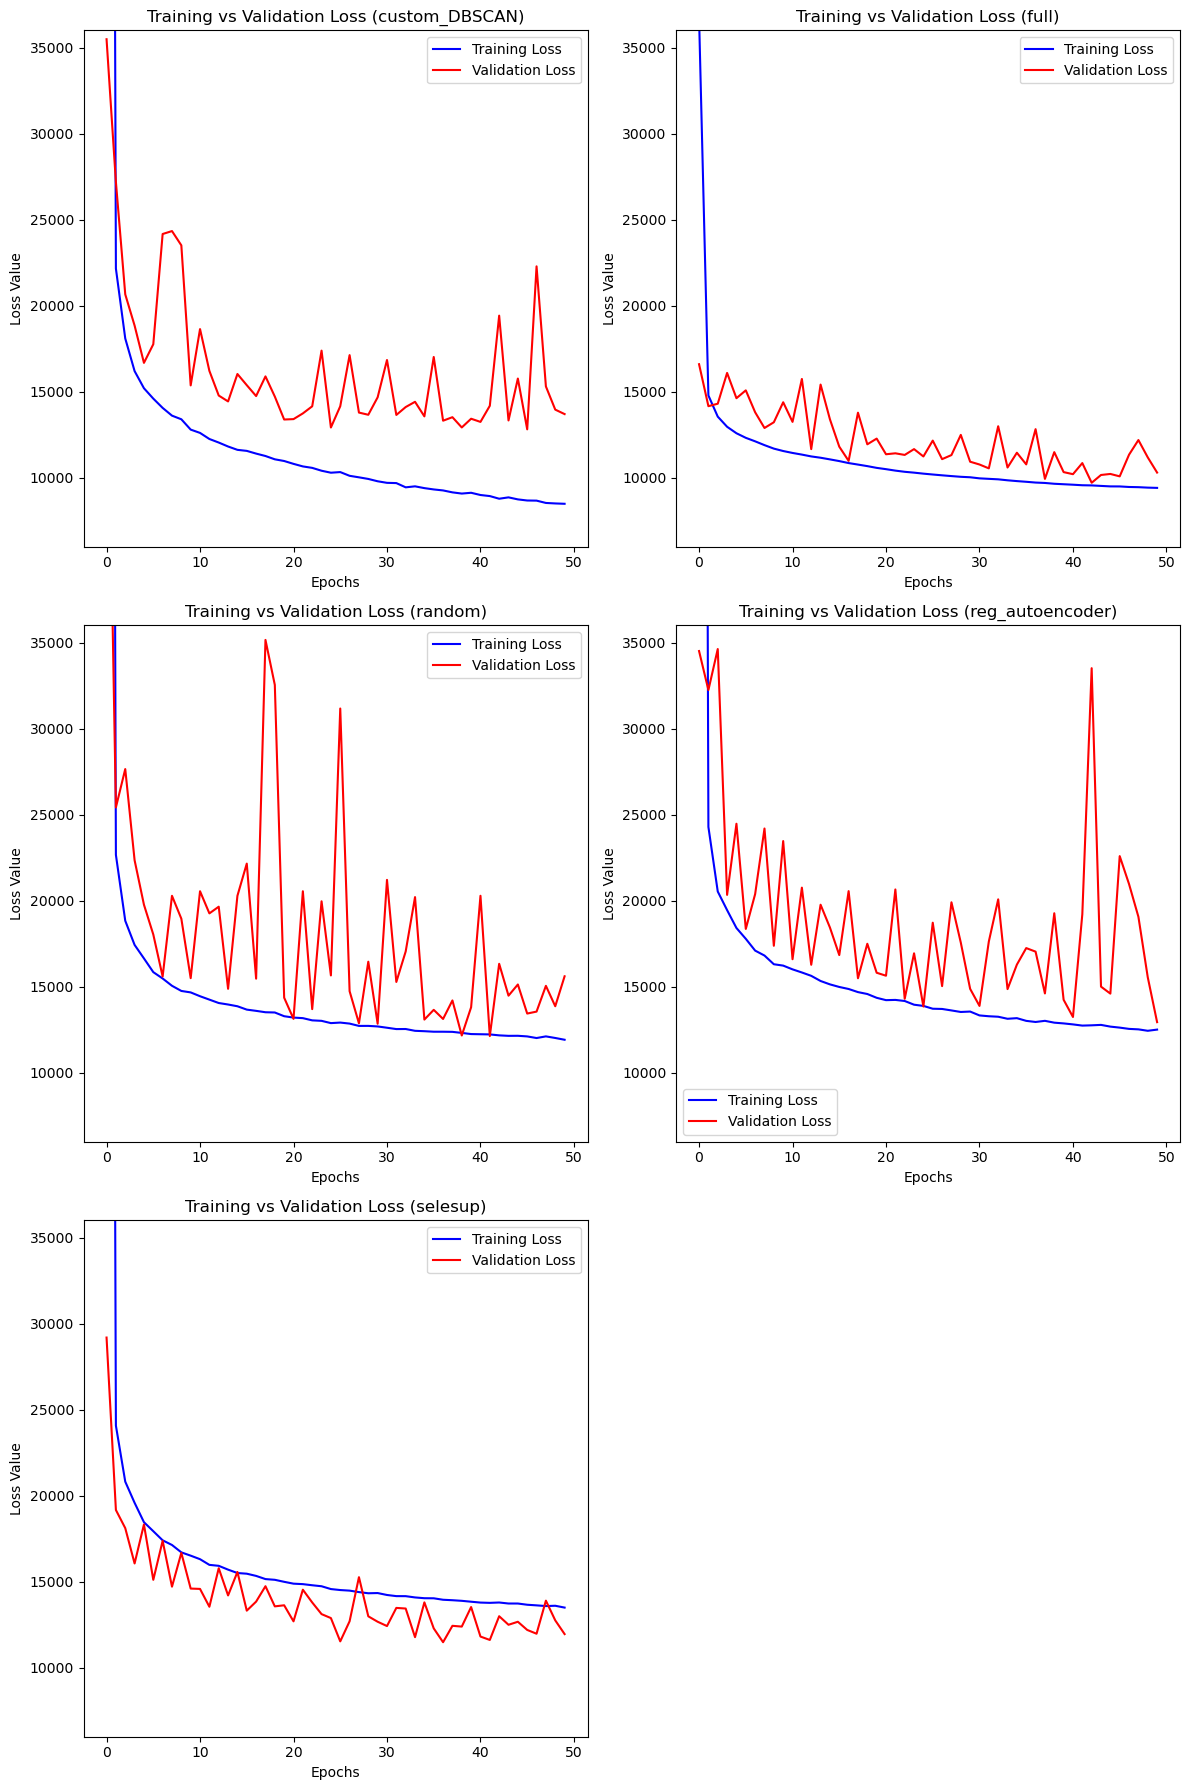

In [3]:
import matplotlib.pyplot as plt
import os
import pickle



root_dir = 'logs_FINAL/'
loaded_hist = {}
for file_name in os.listdir(root_dir):
    method_name = file_name.replace('history_', '').replace('.pkl', '')
    # retrieve history
    history = pickle.load(open(os.path.join(root_dir, file_name), 'rb'))
    loaded_hist[method_name] = history


fig, axes = plt.subplots(3, 2, figsize=(12, 18)) 

# for every method, plot the loss metric graph (MAE)
for ax, (method_name, history) in zip(axes.ravel(), loaded_hist.items()):
    ax.plot(history['loss'], label='Training Loss', color='blue')
    ax.plot(history['val_loss'], label='Validation Loss', color='red')
    if method_name == 'custom': method_name = 'custom_DBSCAN'
    ax.set_title(f'Training vs Validation Loss ({method_name})')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss Value')
    ax.set_ylim(6000, 36000)  # Set y-axis limits
    ax.legend()

# Discard the last graph as they are only 5 methods
fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()


### 4.2 Box plots
### Contains best avg validation and best avg training MAE for every algorithm across the folds

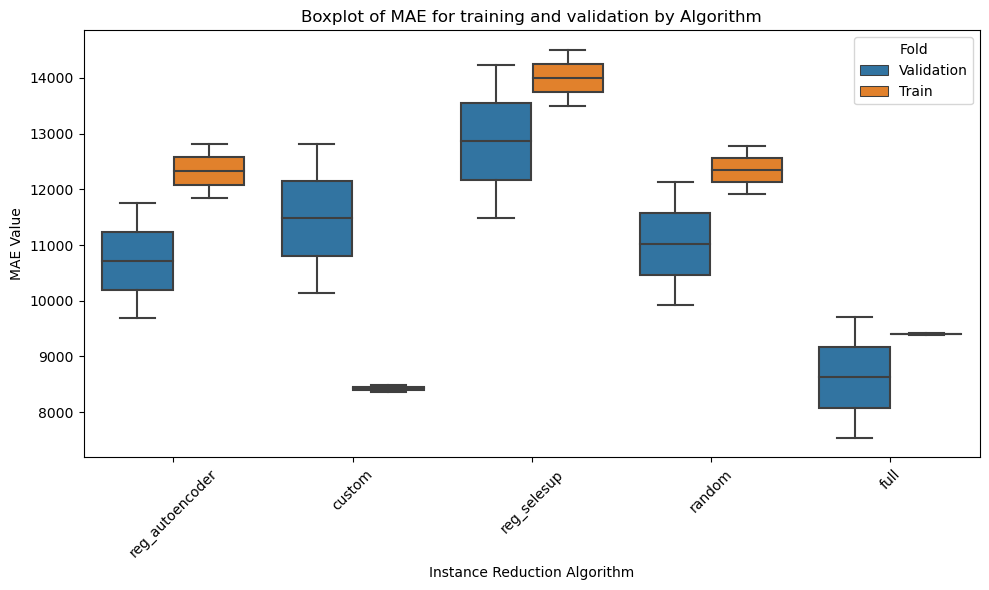

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This data is retrieved from the training in section 3
data = {
    'Fold': ['Validation', 'Validation', 'Train', 'Train', 'Validation', 'Validation', 'Train', 'Train','Validation', 'Validation', 'Train', 'Train','Validation', 'Validation', 'Train', 'Train','Validation', 'Validation', 'Train', 'Train'],
    'Algorithm': ['reg_autoencoder', 'reg_autoencoder', 'reg_autoencoder', 'reg_autoencoder', 'custom', 'custom', 'custom', 'custom', 'reg_selesup', 'reg_selesup', 'reg_selesup', 'reg_selesup', 'random', 'random', 'random', 'random', 'full', 'full', 'full', 'full'],
    'MAE': [9683.7333984375, 11752.0625, 12821.3057 , 11835.8145 , 10137.1884765625, 12819.1435546875, 8360.9082 , 8494.3037 , 14231.0087890625, 11490.19140625, 14505.1738 , 13502.0869 , 9915.3525390625, 12138.0673828125, 12776.5166 , 11924.0586 , 7536.0458984375, 9715.4169921875, 9389.2627 , 9418.1475]
}

df = pd.DataFrame(data)

# Create the boxplot
plt.figure(figsize=(10, 6))  
sns.boxplot(data=df, x='Algorithm', y='MAE', hue='Fold')

plt.title('Boxplot of MAE for training and validation by Algorithm')
plt.ylabel('MAE Value')
plt.xlabel('Instance Reduction Algorithm')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()
